In [1]:
from collections import OrderedDict
import copy
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.optimize as spopt
import platereaderdataloader as prdl

%matplotlib inline

In [2]:
cd "Experiment 1"

/home/kuhlmanlab/Documents/Long Term Evolution Experiments/Experiment 1


In [3]:
days = OrderedDict()

filename_end = ' July 2018 NS001 delta CAT 30 C.xlsx'
platelayout1 = ['0,0,'+str(i) for i in range(1,10)] + ['50,0,'+str(i) for i in range(1,10)] + \
               ['2000,0,'+str(i) for i in range(1,10)] + ['2000,2,'+str(i) for i in range(1,10)] + \
               ['2000,10,'+str(i) for i in range(1,10)] + ['blank1', 'blank2', 'blank3']
platelayout2 = ['2000,0,'+str(i) for i in range(1,10)] + ['2000,2,'+str(i) for i in range(1,10)] + \
               ['2000,10,'+str(i) for i in range(1,10)]  + ['50,0,'+str(i) for i in range(1,10)] + \
               ['0,0,'+str(i) for i in range(1,10)] + ['blank1', 'blank2', 'blank3']

for i in range(9,10):
    filename = str(i) + filename_end
    platelayout180 = copy.copy(platelayout1)
    platelayout180.reverse()
    days[i-9] = prdl.import_platereader(filename, platelayout180)

#for i in range(10,20)
for i in range(10,19):
    filename = str(i) + filename_end
    days[i-9] = prdl.import_platereader(filename,platelayout1)
    
#for i in range(20,27):
    #filename = str(i) + filename_end
    #days[i] = prdl.import_platereader(filename,platelayout2)'''

In [4]:
cd ..

/home/kuhlmanlab/Documents/Long Term Evolution Experiments


In [5]:
cd "Experiment 1 Branch off July 18"

/home/kuhlmanlab/Documents/Long Term Evolution Experiments/Experiment 1 Branch off July 18


In [6]:
# days_branch = OrderedDict()

filename_end_branch = ' 2018 NS001 delta CAT mutation rate titrations.xlsx'

platelayout_branch = platelayout1

treatments = copy.deepcopy(platelayout_branch)
treatments.remove('blank1')
treatments.remove('blank2')
treatments.remove('blank3')
        
for i in range(0,8):
    filename = str(i+24) + ' August' + filename_end_branch
    days[i+10]=prdl.import_platereader(filename, platelayout_branch)
    #days_branch[i]=prdl.import_platereader(filename, platelayout_branch)

for i in range(8,17):
    filename = str(i-7) + ' September' + filename_end_branch
    days[i+10]=prdl.import_platereader(filename, platelayout_branch)
    #days_branch[i]=prdl.import_platereader(filename, platelayout_branch)

In [7]:
cd ..

/home/kuhlmanlab/Documents/Long Term Evolution Experiments


In [8]:
cd "Experiment 1 Branch 1 Continued 28 Sept"

/home/kuhlmanlab/Documents/Long Term Evolution Experiments/Experiment 1 Branch 1 Continued 28 Sept


In [9]:
#days_continue = OrderedDict()

filename_end_continue = ' 2018 NS001 delta CAT mutation rate titrations.xlsx'
        
for i in range(0,4):
    filename = str(i+27) + ' September' + filename_end_branch
    days[i+27]=prdl.import_platereader(filename, platelayout_branch)
    #days_continue[i]=prdl.import_platereader(filename, platelayout_branch)

for i in range(4,15):
    filename = str(i-3) + ' October' + filename_end_branch
    days[i+27] = prdl.import_platereader(filename, platelayout_branch)
    #days_continue[i]=prdl.import_platereader(filename, platelayout_branch)

In [10]:
def shifted_exp(t, P0, r, C):
    return P0*np.exp(r*t)+C

def exp(t, P0, r):
    return P0*np.exp(r*t)

def estimate_blank(data):
    blanks = []
    for key in data:
        b1 = np.mean(data[key]['well_ODs']['blank1'])
        b2 = np.mean(data[key]['well_ODs']['blank2'])
        b3 = np.mean(data[key]['well_ODs']['blank3'])
        blanks.append(np.median(np.array([b1,b2,b3])))
    return np.median(np.array(blanks))

def fit_phases(t, P, cut_below, cut_above, blank=None):
    try:
        i1 = np.where(P<cut_below)[0][0]+1
    except IndexError:
        i1 = 0
    i2 = np.where(P>cut_above)[0][0]
    try:
        if blank is None:
            bounds = (np.array([0, 0, 0]), np.array([np.inf, np.inf, np.inf]))
            popt_exp, pcov_exp = spopt.curve_fit(shifted_exp, t[i1:i2], P[i1:i2], p0=(.002, 1, .08), bounds=bounds)
        else:
            bounds = (np.array([0, 0, blank]), np.array([np.inf, np.inf, blank+.0000001]))
            popt_exp, pcov_exp = spopt.curve_fit(shifted_exp, t[i1:i2], P[i1:i2], p0=(.002, 1, blank), bounds=bounds)
    except RuntimeError:
        popt_exp = np.ones(3)*np.nan
        pcov_exp = np.ones((3,3))*np.nan
    stat_index = np.where(P>.4)[0][0]
    try:
        popt_sta, pcov_sta = spopt.curve_fit(shifted_exp, t[stat_index:], P[stat_index:], p0=(-.1, -.2, .5))
    except RuntimeError:
        popt_sta = np.ones(3)*np.nan
        pcov_sta = np.ones(3)*np.nan
    K_est = np.mean(np.sort(P)[-10:])
    return popt_exp, pcov_exp, popt_sta, pcov_sta, K_est

def fit_over_experiments(data, days, samples, cut_below=.125, cut_above=.24, blank=None):
    popt_exp = OrderedDict()
    pcov_exp = OrderedDict()
    popt_sta = OrderedDict()
    pcov_sta = OrderedDict()
    experiment_days = len(days)
    if blank is not None:
        blank = estimate_blank(data)
    for sample in samples:
        popt_exp[sample]=np.zeros((3,experiment_days))
        pcov_exp[sample]=np.zeros((3,3,experiment_days))
        popt_sta[sample]=np.zeros((3,experiment_days))
        pcov_sta[sample]=np.zeros((3,3,experiment_days))
        for i in range(experiment_days):
            t = data[days[i]]['times']
            P = data[days[i]]['well_ODs'][sample]
            pexp, covexp, psta, covsta, K = fit_phases(t, P, cut_below, cut_above, blank=blank)
            popt_exp[sample][:,i] = pexp
            pcov_exp[sample][:,:,i] = covexp
            popt_sta[sample][:,i] = psta
            pcov_sta[sample][:,:,i] = covsta
    return popt_exp, pcov_exp, popt_sta, pcov_sta, blank

In [11]:
pexps, covexps, pstas, covstas, blank = fit_over_experiments(days, range(42), treatments, blank=1)

/home/kuhlmanlab/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


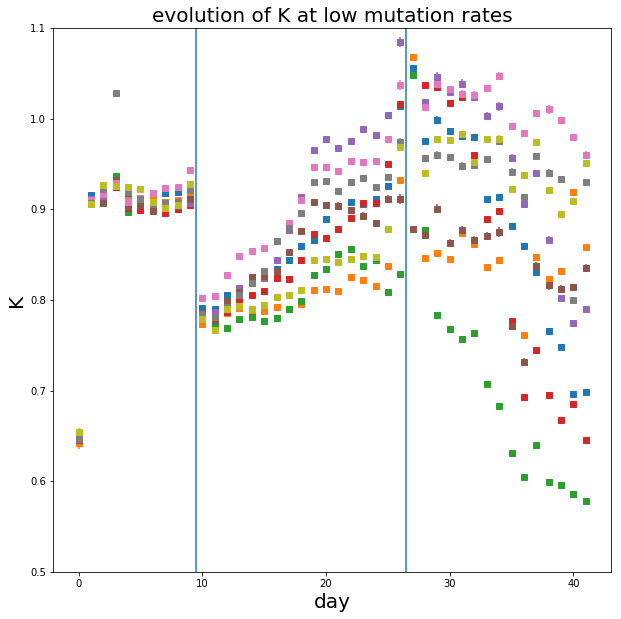

In [12]:
plt.figure(figsize=(10,10))
param = 2
for sample in ['2000,10,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pstas[sample][param], yerr=covstas[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of K at low mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('K', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(.5,1.1);

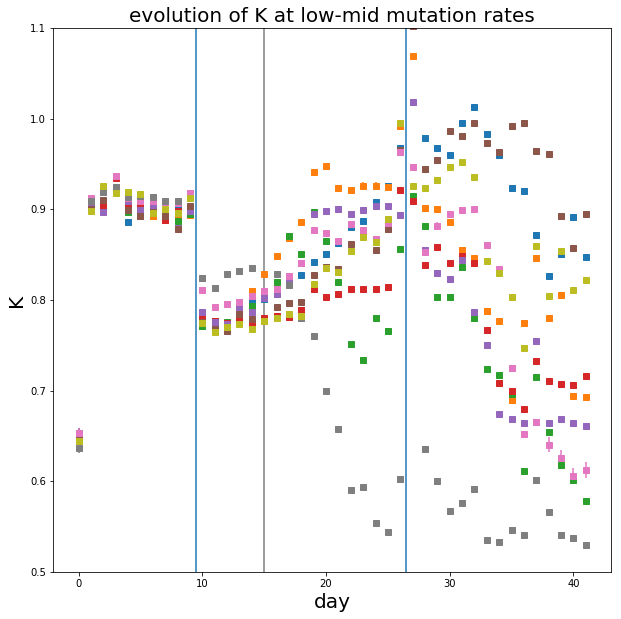

In [13]:
plt.figure(figsize=(10,10))
param = 2
for sample in ['2000,2,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pstas[sample][param], yerr=covstas[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of K at low-mid mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('K', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(.5,1.1);

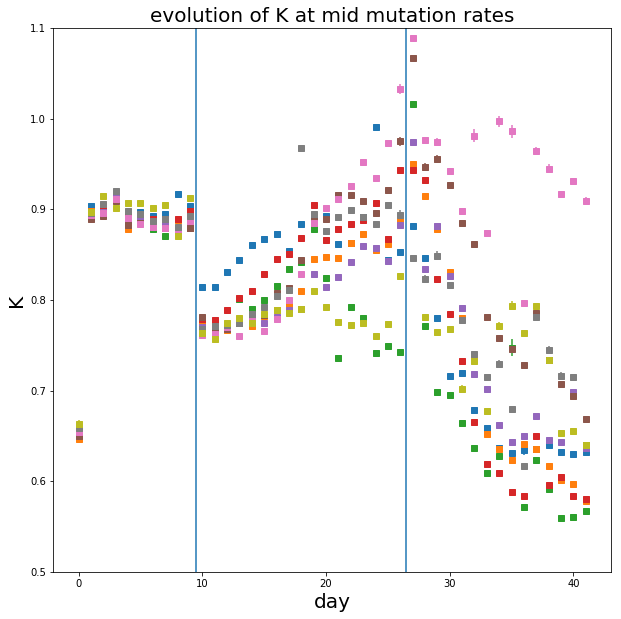

In [14]:
plt.figure(figsize=(10,10))
param = 2
for sample in ['2000,0,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pstas[sample][param], yerr=covstas[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of K at mid mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('K', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(.5,1.1);

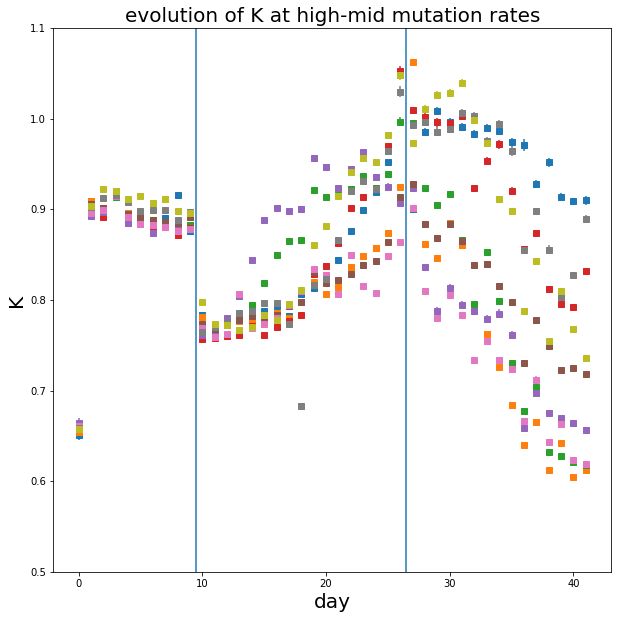

In [15]:
plt.figure(figsize=(10,10))
param = 2
for sample in ['50,0,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pstas[sample][param], yerr=covstas[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of K at high-mid mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('K', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(.5,1.1);

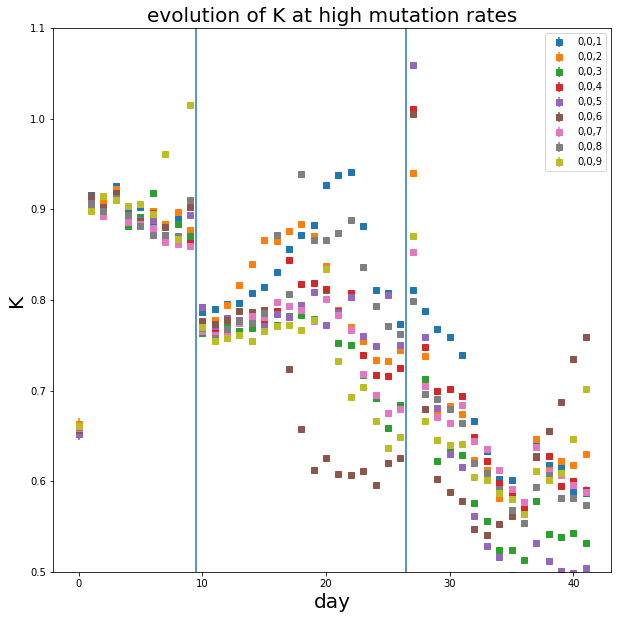

In [16]:
plt.figure(figsize=(10,10))
param = 2
for sample in ['0,0,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pstas[sample][param], yerr=covstas[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of K at high mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('K', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
plt.legend()
plt.ylim(.5,1.1);

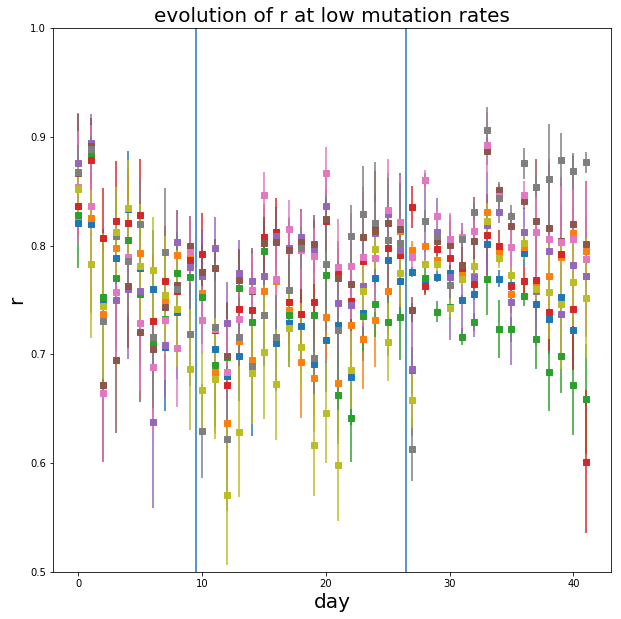

In [17]:
plt.figure(figsize=(10,10))
param = 1
for sample in ['2000,10,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pexps[sample][param], yerr=covexps[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of r at low mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('r', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(.5,1.0);

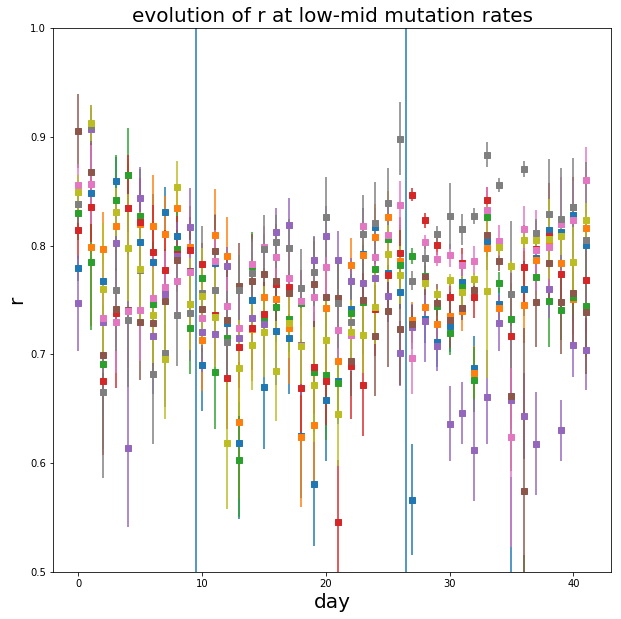

In [18]:
plt.figure(figsize=(10,10))
param = 1
for sample in ['2000,2,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pexps[sample][param], yerr=covexps[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of r at low-mid mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('r', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(.5,1.0);

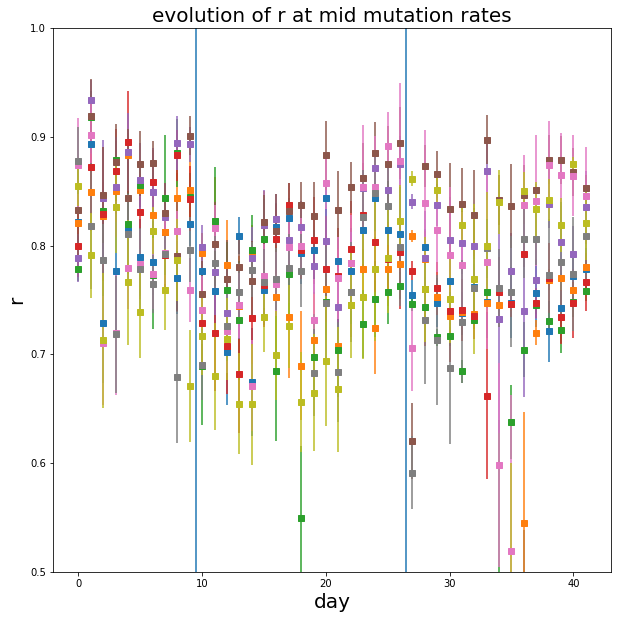

In [19]:
plt.figure(figsize=(10,10))
param = 1
for sample in ['2000,0,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pexps[sample][param], yerr=covexps[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of r at mid mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('r', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(.5,1.0);

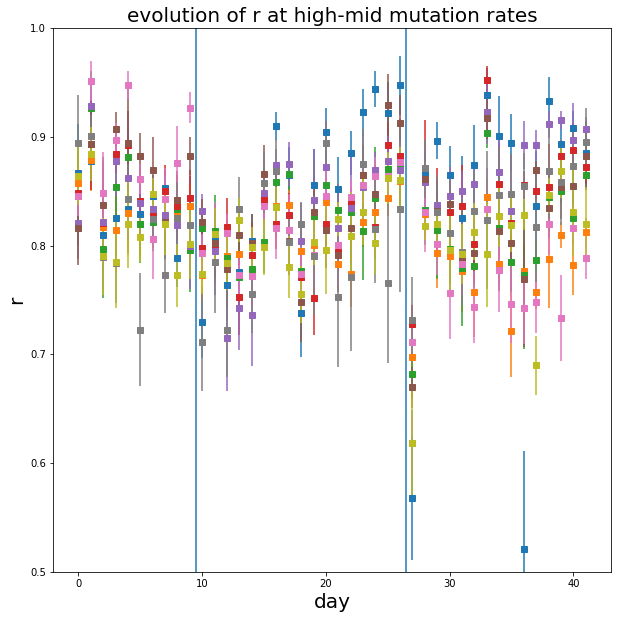

In [20]:
plt.figure(figsize=(10,10))
param = 1
for sample in ['50,0,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pexps[sample][param], yerr=covexps[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of r at high-mid mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('r', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(.5,1.0);

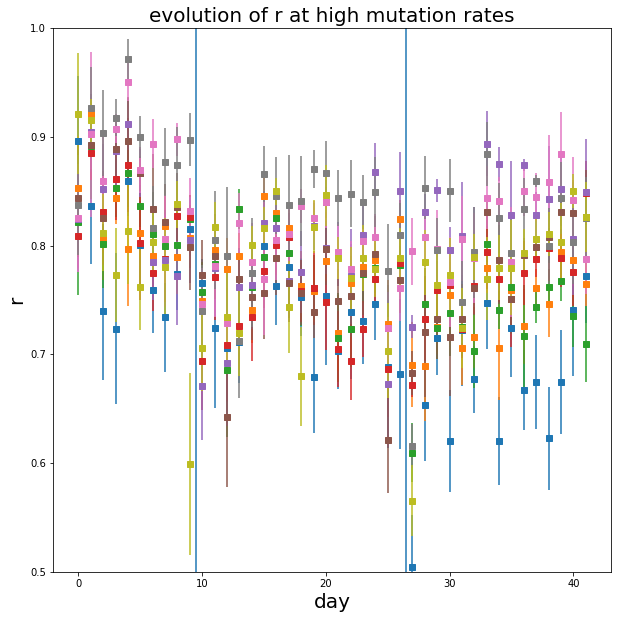

In [21]:
plt.figure(figsize=(10,10))
param = 1
for sample in ['0,0,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pexps[sample][param], yerr=covexps[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of r at high mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('r', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(.5,1.0);

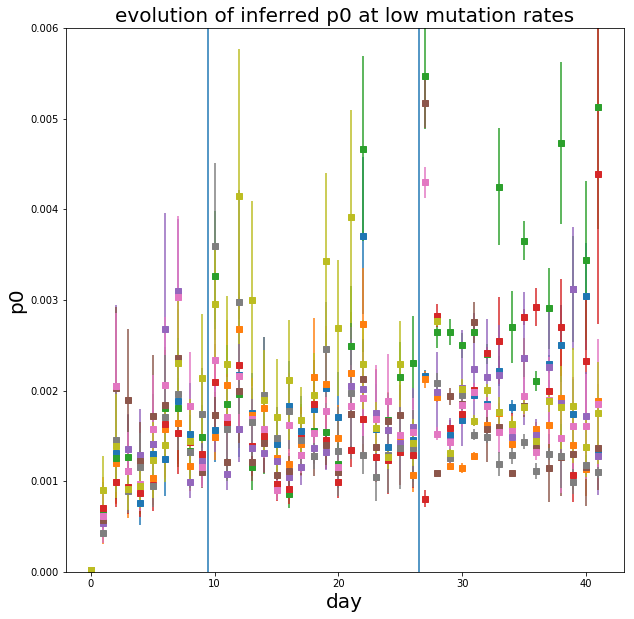

In [22]:
plt.figure(figsize=(10,10))
param = 0
for sample in ['2000,10,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pexps[sample][param], yerr=covexps[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of inferred p0 at low mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('p0', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(0,.006);

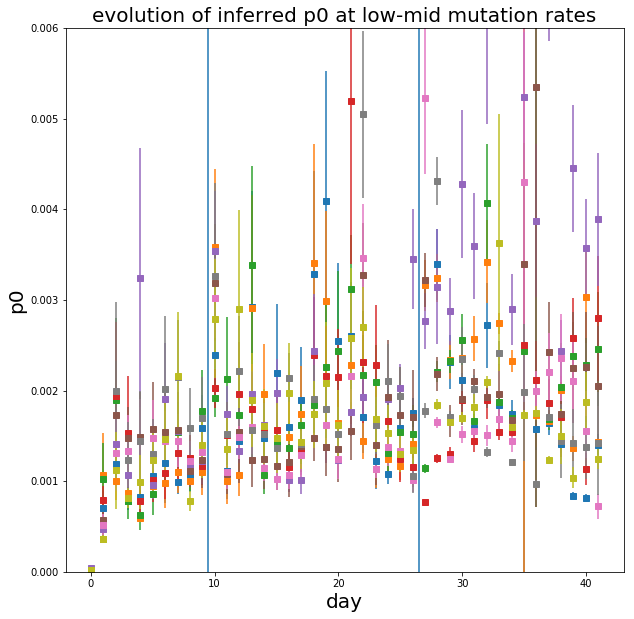

In [23]:
plt.figure(figsize=(10,10))
param = 0
for sample in ['2000,2,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pexps[sample][param], yerr=covexps[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of inferred p0 at low-mid mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('p0', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(0,.006);

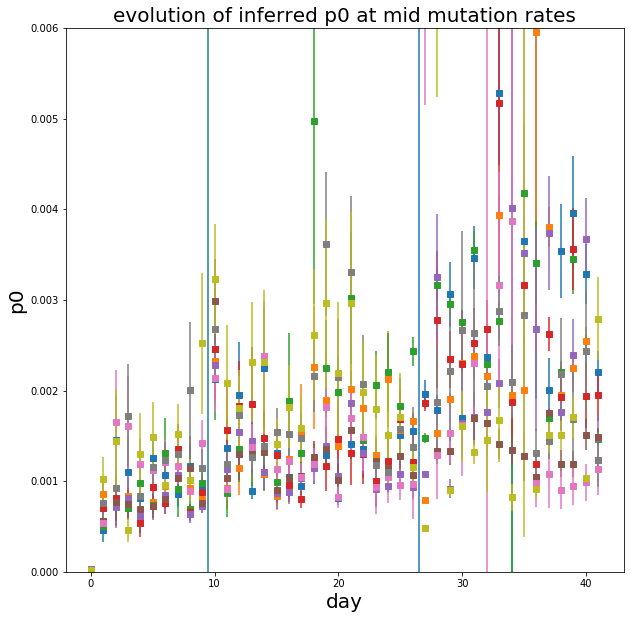

In [24]:
plt.figure(figsize=(10,10))
param = 0
for sample in ['2000,0,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pexps[sample][param], yerr=covexps[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of inferred p0 at mid mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('p0', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(0,.006);

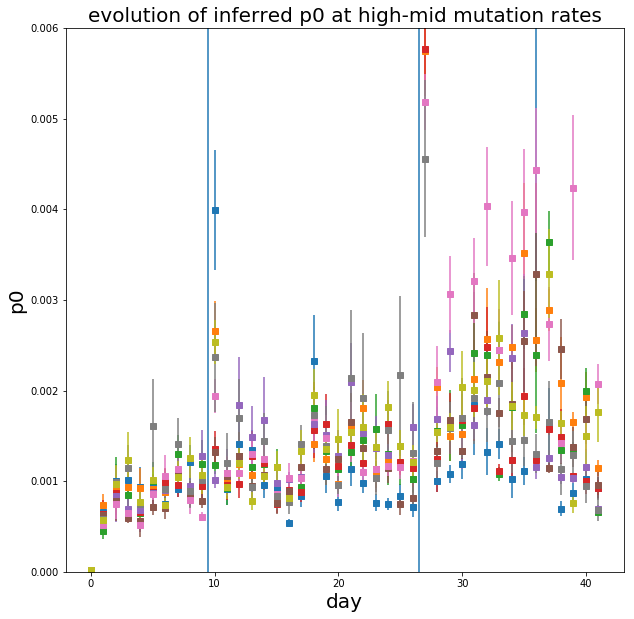

In [25]:
plt.figure(figsize=(10,10))
param = 0
for sample in ['50,0,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pexps[sample][param], yerr=covexps[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of inferred p0 at high-mid mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('p0', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(0,.006);

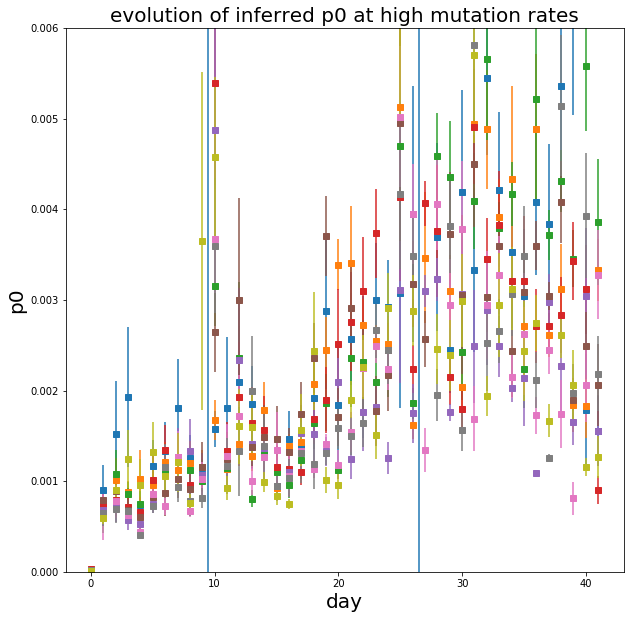

In [26]:
plt.figure(figsize=(10,10))
param = 0
for sample in ['0,0,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pexps[sample][param], yerr=covexps[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of inferred p0 at high mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('p0', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
#plt.legend()
plt.ylim(0,.006);

(0, 0.2)

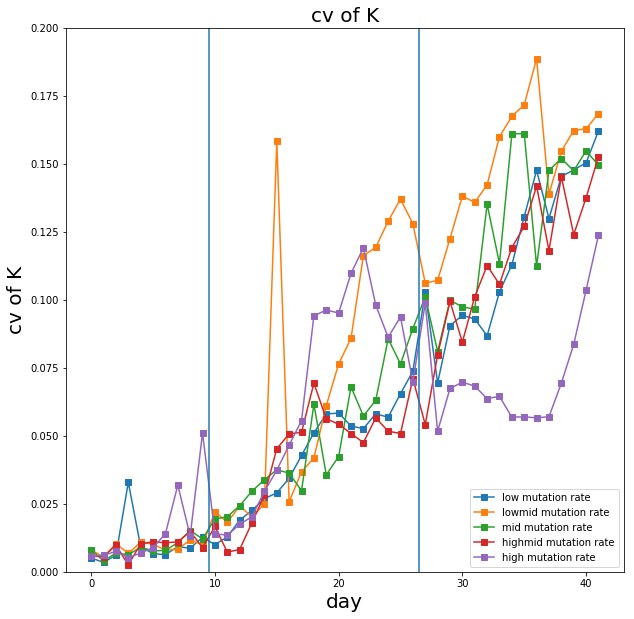

In [27]:
plt.figure(figsize=(10,10))
param = 2
K_lows = np.array([pstas[sample][param] for sample in ['2000,10,'+str(i) for i in range(1,10)]])
K_lowmids = np.array([pstas[sample][param] for sample in ['2000,2,'+str(i) for i in range(1,10)]])
K_mids = np.array([pstas[sample][param] for sample in ['2000,0,'+str(i) for i in range(1,10)]])
K_highmids = np.array([pstas[sample][param] for sample in ['50,0,'+str(i) for i in range(1,10)]])
K_highs = np.array([pstas[sample][param] for sample in ['0,0,'+str(i) for i in range(1,10)]])
plt.plot(np.arange(42), np.std(K_lows,axis=0)/np.mean(K_lows,axis=0), linestyle='-', marker='s', label='low mutation rate')
plt.plot(np.arange(42), np.std(np.minimum(K_lowmids,1.22),axis=0)/np.mean(np.minimum(K_lowmids,1.22),axis=0), linestyle='-', marker='s', label='lowmid mutation rate')
plt.plot(np.arange(42), np.std(K_mids,axis=0)/np.mean(K_mids,axis=0), linestyle='-', marker='s', label='mid mutation rate')
plt.plot(np.arange(42), np.std(K_highmids,axis=0)/np.mean(K_highmids,axis=0), linestyle='-', marker='s', label='highmid mutation rate')
plt.plot(np.arange(42), np.std(K_highs,axis=0)/np.mean(K_highs,axis=0), linestyle='-', marker='s', label='high mutation rate')
plt.title('cv of K',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('cv of K', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
plt.legend()
plt.ylim(0,.2)

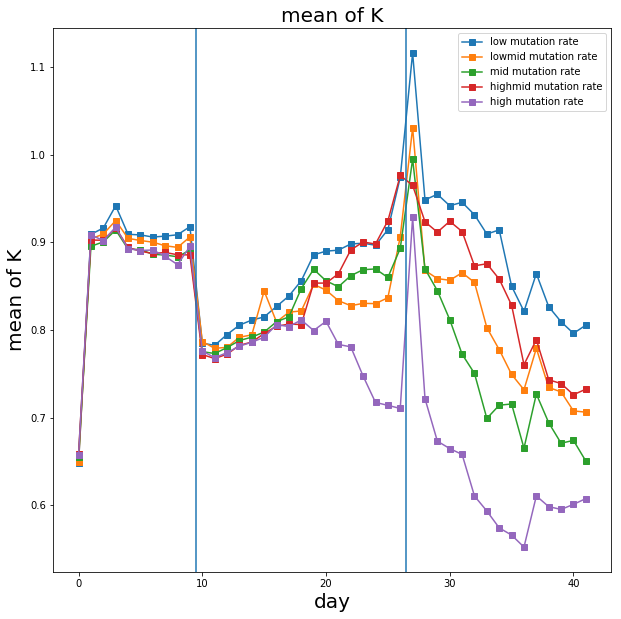

In [28]:
plt.figure(figsize=(10,10))
param = 2
K_lows = np.array([pstas[sample][param] for sample in ['2000,10,'+str(i) for i in range(1,10)]])
K_lowmids = np.array([pstas[sample][param] for sample in ['2000,2,'+str(i) for i in range(1,10)]])
K_mids = np.array([pstas[sample][param] for sample in ['2000,0,'+str(i) for i in range(1,10)]])
K_highmids = np.array([pstas[sample][param] for sample in ['50,0,'+str(i) for i in range(1,10)]])
K_highs = np.array([pstas[sample][param] for sample in ['0,0,'+str(i) for i in range(1,10)]])
plt.plot(np.arange(42), np.mean(K_lows,axis=0), linestyle='-', marker='s', label='low mutation rate')
plt.plot(np.arange(42), np.mean(np.minimum(K_lowmids,1.22),axis=0), linestyle='-', marker='s', label='lowmid mutation rate')
plt.plot(np.arange(42), np.mean(K_mids,axis=0), linestyle='-', marker='s', label='mid mutation rate')
plt.plot(np.arange(42), np.mean(K_highmids,axis=0), linestyle='-', marker='s', label='highmid mutation rate')
plt.plot(np.arange(42), np.mean(K_highs,axis=0), linestyle='-', marker='s', label='high mutation rate')
plt.title('mean of K',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('mean of K', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
plt.legend()
#plt.ylim(0,.2)

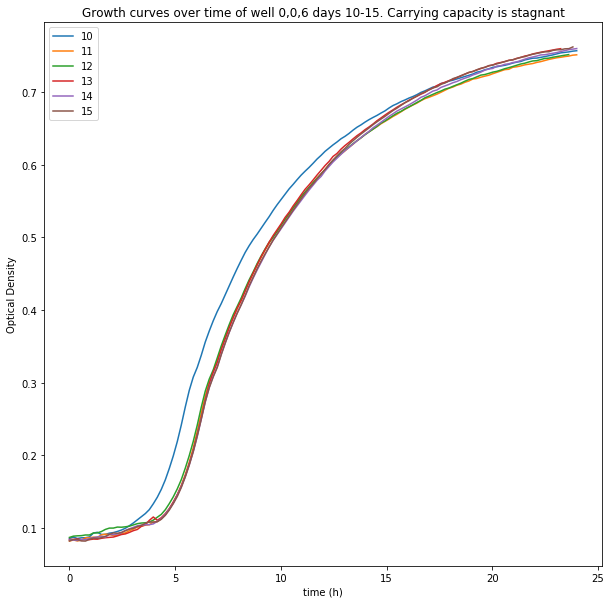

In [29]:
plt.figure(figsize=(10,10))
sample='0,0,6'
for i in range(10,16):
    t = days[i]['times']
    P = days[i]['well_ODs'][sample]
    plt.plot(t, P, label=str(i))
plt.xlabel('time (h)');
plt.ylabel('Optical Density')
plt.title('Growth curves over time of well 0,0,6 days 10-15. Carrying capacity is stagnant')
plt.legend()

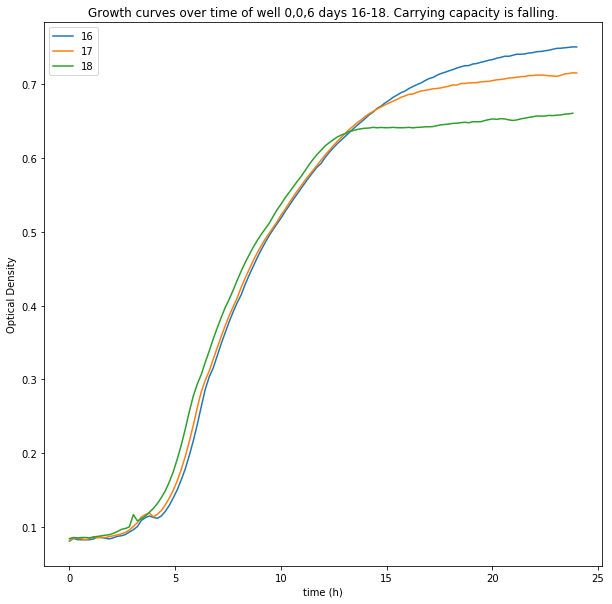

In [30]:
plt.figure(figsize=(10,10))
sample='0,0,6'
for i in range(16,19):
    t = days[i]['times']
    P = days[i]['well_ODs'][sample]
    plt.plot(t, P, label=str(i))
plt.xlabel('time (h)');
plt.ylabel('Optical Density')
plt.title('Growth curves over time of well 0,0,6 days 16-18. Carrying capacity is falling.')
plt.legend()

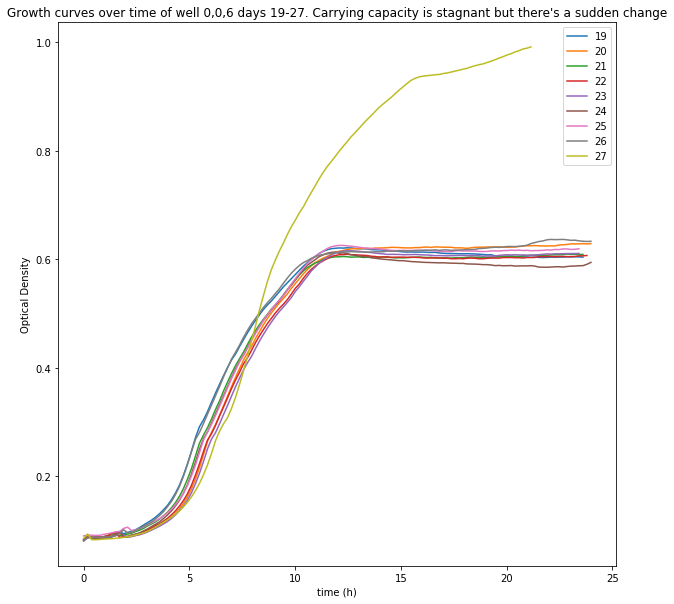

In [31]:
plt.figure(figsize=(10,10))
sample='0,0,6'
for i in range(19,28):
    t = days[i]['times']
    P = days[i]['well_ODs'][sample]
    plt.plot(t, P, label=str(i))
plt.xlabel('time (h)');
plt.ylabel('Optical Density')
plt.title("Growth curves over time of well 0,0,6 days 19-27. Carrying capacity is stagnant but there's a sudden change")
plt.legend()

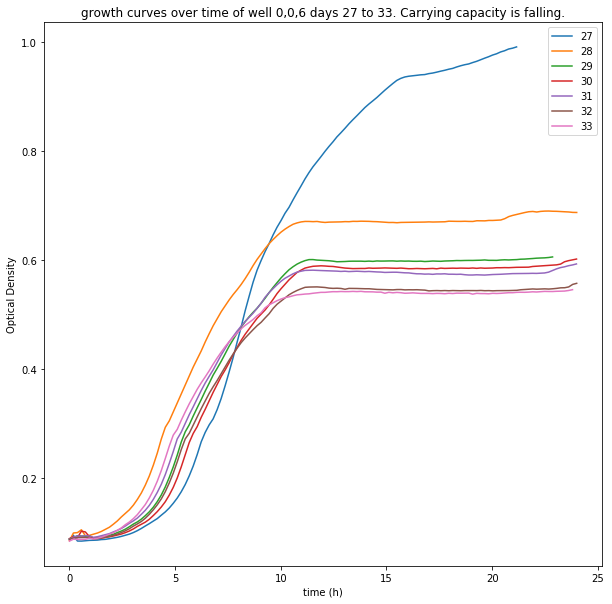

In [32]:
plt.figure(figsize=(10,10))
sample='0,0,6'
for i in range(27,34):
    t = days[i]['times']
    P = days[i]['well_ODs'][sample]
    plt.plot(t, P, label=str(i))
plt.xlabel('time (h)');
plt.ylabel('Optical Density')
plt.title('growth curves over time of well 0,0,6 days 27 to 33. Carrying capacity is falling.')
plt.legend()

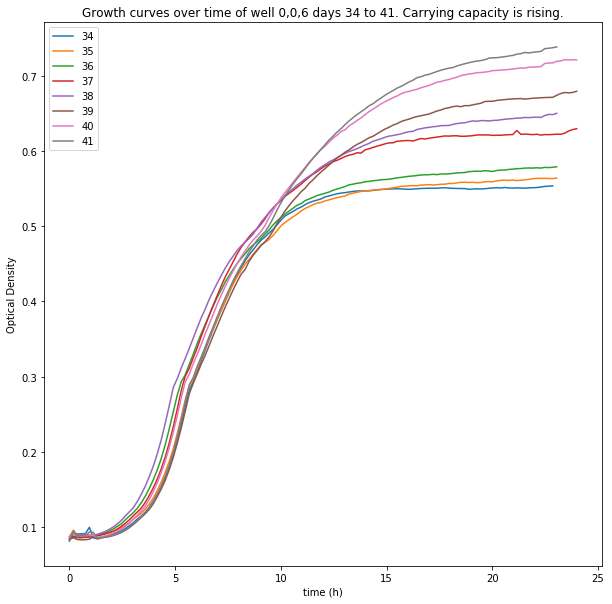

In [33]:
plt.figure(figsize=(10,10))
sample='0,0,6'
for i in range(34,42):
    t = days[i]['times']
    P = days[i]['well_ODs'][sample]
    plt.plot(t, P, label=str(i))
plt.xlabel('time (h)');
plt.ylabel('Optical Density')
plt.title('Growth curves over time of well 0,0,6 days 34 to 41. Carrying capacity is rising.')
plt.legend()

(0.5, 1)

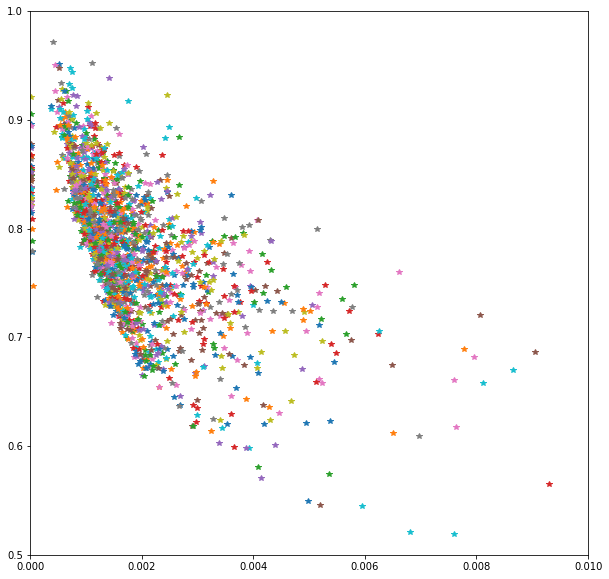

In [43]:
plt.figure(figsize=(10,10))
_p0 = 0
_r = 1
for i in range(42):
    for sample in treatments:
        plt.plot(pexps[sample][_p0][i], pexps[sample][_r][i], '*')
plt.xlim(0,.01)
plt.ylim(.5, 1)

In [44]:
import matplotlib.patches as patch

In [108]:
def plot_center_and_ellipse(sample, day):
    p0_center = pexps[sample][0][day]
    r_center = pexps[sample][1][day]
    cov = np.array([[ covexps[sample][0,0][day], covexps[sample][0,1][day] ],
                    [ covexps[sample][1,0][day], covexps[sample][1,1][day] ]])
    w, v = np.linalg.eig(cov)
    height = w[1]**.5
    width = w[0]**.5
    angle = np.arctan(v[0,1]/v[0,0])
    axes = plt.subplot(111)
    axes.plot(p0_center, r_center, 'r*')
    ell = patch.Ellipse((p0_center, r_center), width, height, angle, facecolor='red', visible=True, fill=True, alpha = .5)
    axes.add_artist(ell)

[[-0.99995907  0.0090479 ]
 [-0.0090479  -0.99995907]]


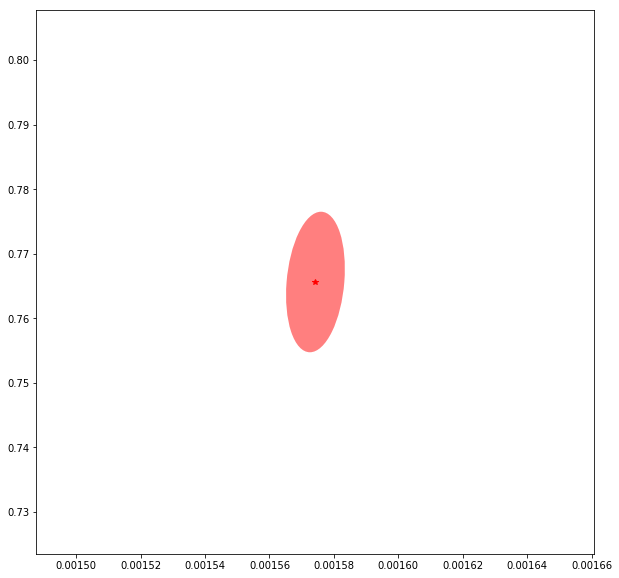

In [106]:
plt.figure(figsize=(10,10))
plot_center_and_ellipse('0,0,1', 10)

(0.5, 1)

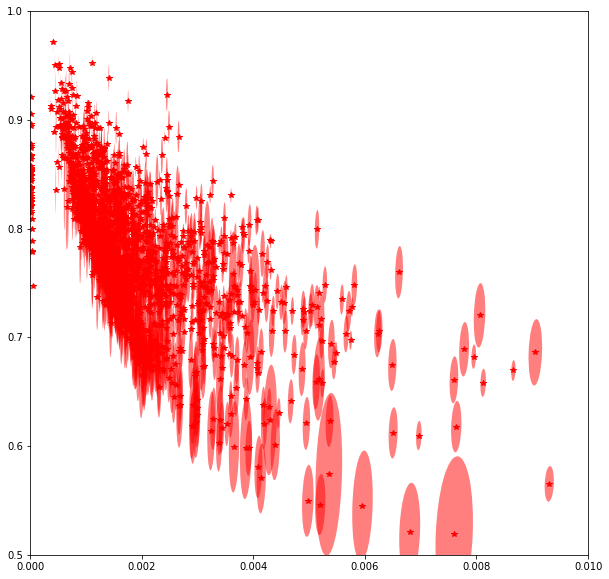

In [109]:
plt.figure(figsize=(10,10))
_p0 = 0
_r = 1
for i in range(42):
    for sample in treatments:
        plot_center_and_ellipse(sample, i)
plt.xlim(0,.01)
plt.ylim(.5, 1)